In [1]:
import os
import sys

sys.path.append("..")

import pandas as pd
import numpy as np
import random
import time
import copy

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from deconfounder.deconfounder_tree_tmp import DeconfounderTree
from deconfounder.causal_tree import CausalTree
from metrics import uplift_curve, TOC_at_k, RATE, AUPEC
import matplotlib.pyplot as plt


Load STAR data and prepare data for experiment

In [2]:
star_data = pd.read_csv("../data/STAR_Students_Encoded.csv")

# # Features used in the paper (Removing Hidden Confounding by Experimental Grounding)
# cat_covar_columns = ['gender', 'race', 'birthmonth', 'birthday', 'birthyear', 'gkfreelunch',\
#     'g1tchid', 'g1freelunch']

cat_covar_columns = ['gender', 'race', 'birthmonth', 'birthday', 'birthyear', 'gkfreelunch',\
    'g1schid', 'g1surban', 'g1tchid', 'g1trace', 'g1thighdegree', 'g1tcareer', 'g1tyears', 'g1freelunch']
num_covar_columns = ['gktreadss', 'gktmathss', 'gktlistss']
Y_columns = [ 'g1treadss', 'g1tmathss', 'g1tlistss']

treatment_filter = np.isfinite(star_data.g1classtype)
outcome_filter = np.isfinite(star_data.g1tlistss + star_data.g1treadss + star_data.g1tmathss)

T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values
X_all = star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)].fillna(0)
X_all['hasaide'] = np.array(T_all==3, dtype='int')      # Add a feature about whether the student's class has an aide
cat_covar_columns.append('hasaide')
Y_cols = star_data[Y_columns][np.logical_and(treatment_filter, outcome_filter)].values
Y_all = np.sum(Y_cols, axis=1)/3

assert(len(X_all) == len(Y_all) == len(T_all))

T_exp = T_all[T_all!=3] # removing 3 from T, only including data of small and regular class (no aide)
T_exp[T_exp == 2] = 0 
X_exp = X_all[T_all!=3]
Y_exp = Y_all[T_all!=3]

assert(len(X_exp) == len(Y_exp) == len(T_exp))

print('Full data set size               : ', star_data.shape[0])
print('Remove treatment and outcome NaNs: ', T_all.shape[0])
print('Remove T = 3                     : ', T_exp.shape[0])

# plt.hist(Y_exp[T_exp==0], alpha = 0.5,label='control', bins=50, density=True)
# plt.hist(Y_exp[T_exp==1], alpha = 0.5,label='treated', bins=50, density=True)
# plt.legend()
# plt.show()

Full data set size               :  11601
Remove treatment and outcome NaNs:  6322
Remove T = 3                     :  4218


In [3]:
random.seed(42)
state = random.randint(1, 1e5)

# Split data into train and test set
X_dec, X_test, Y_dec, Y_test, T_dec, T_test = train_test_split(X_exp, Y_exp, T_exp, test_size=0.5, random_state=state)

Fit causal tree on experimental data (small vs regular class)

In [4]:
def get_best_model_from_gridcv(X, y, model_param_pairs, random_search=False, n_jobs=None):
    val_errs = []
    models = []
    start_time = time.time()
    for model, params in model_param_pairs:
        if random_search:
            grid_search = RandomizedSearchCV(model, params, cv=5, n_jobs=n_jobs)
        else:
            grid_search = GridSearchCV(model, params, cv=5, n_jobs=n_jobs)
        grid_search.fit(X, y)
        val_errs.append(grid_search.best_score_)
        print(str(grid_search.best_estimator_))
        models.append(copy.deepcopy(grid_search.best_estimator_))

    best_ind = val_errs.index(min(val_errs))
    print("Best model:", str(models[best_ind]))
    print("--- Time to fit (and tune) scoring model %s seconds ---" % (time.time() - start_time))
    return copy.deepcopy(models[best_ind])

def evaluate(metric, y_true, priority_score, treatment, k=0.1, percentile=0.9):
    if metric=="TOC_10%":
        return TOC_at_k(y_true, priority_score, treatment, k)
    elif metric=="AUTOC":
        return RATE(y_true, priority_score, treatment, method="AUTOC")
    elif metric=="QINI":
        return RATE(y_true, priority_score, treatment, method="QINI")
    elif metric=="AUPEC":
        return AUPEC(y_true, priority_score, treatment, percentile)
    else:
        raise ValueError(f"metric={metric} should be 'TOC_10%', 'AUTOC', 'QINI' or 'AUPEC'")

CausalTree(criterion=<mse_causal.CausalCriterion object at 0x000001C801B77D40>,
           min_samples_leaf=40)
Best model: CausalTree(criterion=<mse_causal.CausalCriterion object at 0x000001C801B748C0>,
           min_samples_leaf=40)
--- Time to fit (and tune) scoring model 1.8457045555114746 seconds ---
TOC_10% of Causal Tree: 19.980794311390355
AUTOC of Causal Tree: 9.00989943008667
QINI of Causal Tree: 4.3950564370758


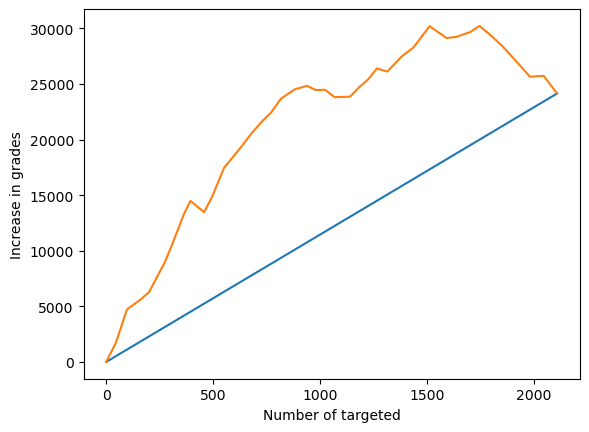

In [5]:
ct_param_pairs = [(CausalTree(), {'min_samples_leaf': range(10, 300, 10)})]
X_dec_with_T = X_dec.copy()
X_dec_with_T['treated'] = T_dec
causal_model = get_best_model_from_gridcv(X_dec_with_T, Y_dec, ct_param_pairs, n_jobs=4)
eff_test = causal_model.predict(X_test)

n_test = T_test.shape[0]
uplift_all = (Y_test[T_test==1].mean() - Y_test[T_test==0].mean()) * n_test
uplift_ct = uplift_curve(Y_test, eff_test, T_test)
plt.plot([0, n_test], [0, uplift_all], label='Random Model')
plt.plot(uplift_ct[0], uplift_ct[1], label='Causal Tree')
plt.xlabel('Number of targeted')
plt.ylabel('Increase in grades')

print("TOC_10% of Causal Tree:", evaluate('TOC_10%', Y_test, eff_test, T_test, 0.1))
print("AUTOC of Causal Tree:", evaluate('AUTOC', Y_test, eff_test, T_test))
print("QINI of Causal Tree:", evaluate('QINI', Y_test, eff_test, T_test))
# print("AUPEC of Causal Tree:", evaluate('AUPEC', Y_test, eff_test, T_test))

Fit scoring model 

In [6]:
# Prepare data for scoring model
X_sm = pd.concat([X_dec[T_dec==0], X_all[T_all==3]], axis=0)    # Regular class part in training data + regular class with an aide
Y_sm = np.r_[Y_dec[T_dec==0], Y_all[T_all==3]]
assert(len(X_sm) == len(Y_sm))

In [7]:
# Scoring model set (tree-based models)

reg_param_pairs = []
# ## Random forest
# reg_parameter_pairs = [(RandomForestRegressor(), 
#                         {#'max_depth':[None] + list(range(2,11,4)),
#                             'min_samples_leaf': list(range(10, 50, 10)), 
#                             'n_estimators':[10, 50, 100, 150, 200]})]

# # ADABOOST REGRESSION
# reg_parameter_pairs.append((AdaBoostRegressor(),
#                             {#'loss':['linear', 'square', 'exponential'],
#                              'n_estimators':[10, 50, 100, 150, 200]}))

# # REGRESSION TREES
# reg_parameter_pairs.append((DecisionTreeRegressor(),
#                             {'max_depth':list(range(4,20,3))}))

# # GRADIENT BOOSTED REGRESSION TREES
# reg_parameter_pairs.append((GradientBoostingRegressor(),
#                             {#'loss':['ls', 'lad', 'huber'],
#                              #'max_depth':list(range(2,7,4)),
#                              'min_samples_leaf': [10, 30, 50, 100, 150],
#                              'n_estimators':[10, 50, 100, 150, 200]}))

# LIGHTGBM
reg_param_pairs.append((LGBMRegressor(),
                         {'reg_lambda': [0.01, 0.1, 0.2],
                         'min_child_samples': list(range(20, 300, 10)),
                         'n_estimators': [10, 20, 50, 100, 150, 200, 250, 300, 400],
                         'subsample': np.arange(0.2, 0.95, 0.1),
                         'colsample_bytree': np.arange(0.2, 0.95, 0.1)
                         }))

best_sm_model = get_best_model_from_gridcv(X_sm, Y_sm, reg_param_pairs, random_search=True, n_jobs=4)
priority_score = -1 * best_sm_model.predict(X_test.values)      # Priotrize lower grades
priority_score_dec = -1 * best_sm_model.predict(X_dec.values)


LGBMRegressor(colsample_bytree=0.30000000000000004, min_child_samples=90,
              n_estimators=200, reg_lambda=0.2, subsample=0.4000000000000001)
Best model: LGBMRegressor(colsample_bytree=0.30000000000000004, min_child_samples=90,
              n_estimators=200, reg_lambda=0.2, subsample=0.4000000000000001)
--- Time to fit (and tune) scoring model 0.9757287502288818 seconds ---


In [8]:
# Scoring model set (linear regression models)

# def fit_encoder_for_lr(df, num_covar_cols, cat_covar_cols):
#     ct = ColumnTransformer(
#         transformers=[('num', StandardScaler(), num_covar_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_covar_cols)]
#     )
#     ct = ct.fit(df)
#     return ct

# # LINEAR REGRESSION
# lr_param_pairs = []
# ## LASSO
# lr_param_pairs.append((Lasso(), 
#                        {'alpha': [1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]}))
# # # RIDGE
# lr_param_pairs.append((Ridge(), 
#                        {'alpha':[1e-5,1e-3,1e-1,1,1e+1,1e+3,1e+5]}))

# encoder = fit_encoder_for_lr(X_sm, num_covar_cols=[], cat_covar_cols=cat_covar_columns)   # One hot encoding
# best_sm_model = get_best_model_from_gridcv(encoder.transform(X_sm), Y_sm, lr_param_pairs, n_jobs=2)

# # Score on train and test set
# priority_score = -1 * best_sm_model.predict(encoder.transform(X_test))
# priority_score_dec = -1 * best_sm_model.predict(encoder.transform(X_dec))

Fit deconfounder tree

In [9]:

# Fit deconfounder tree
dec_param_pairs = [(DeconfounderTree(), 
                    {'max_depth': list(range(1, 4, 1)),
                    'min_samples_leaf': list(range(20, 300, 20))})]

best_deconfounder = get_best_model_from_gridcv(
    X_dec.values, 
    np.c_[T_dec, Y_dec, priority_score_dec, np.zeros(T_dec.shape[0])],
    dec_param_pairs,
    n_jobs=4
    )

# Score on test set
corrected_score = priority_score - best_deconfounder.predict(X_test.values)

DeconfounderTree(criterion=<deconfound_criterion.DeconfoundCriterion object at 0x000001C801A9C760>,
                 max_depth=3, min_samples_leaf=20)
Best model: DeconfounderTree(criterion=<deconfound_criterion.DeconfoundCriterion object at 0x000001C801A99B30>,
                 max_depth=3, min_samples_leaf=20)
--- Time to fit (and tune) scoring model 0.4868347644805908 seconds ---


Uplift curves for different scores

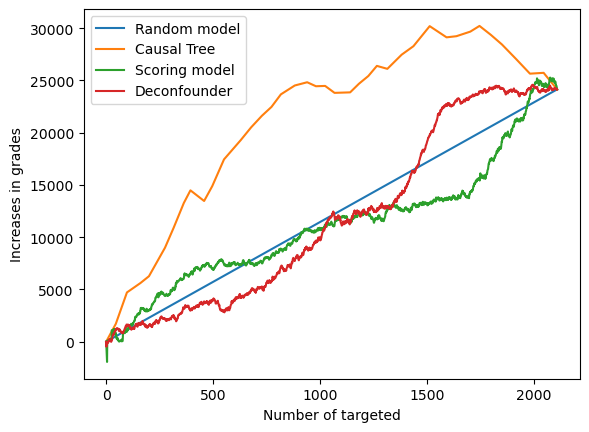

In [10]:
n_test = T_test.shape[0]
uplift_all = (Y_test[T_test==1].mean() - Y_test[T_test==0].mean()) * len(Y_test)
uplift_ct = uplift_curve(Y_test, eff_test, T_test)
uplift_sm = uplift_curve(Y_test, priority_score, T_test)
uplift_dec = uplift_curve(Y_test, corrected_score, T_test)

plt.plot([0, n_test], [0, uplift_all], label='Random model')
plt.plot(uplift_ct[0], uplift_ct[1], label='Causal Tree')
plt.plot(uplift_sm[0], uplift_sm[1], label='Scoring model')
plt.plot(uplift_dec[0], uplift_dec[1], label='Deconfounder')
plt.xlabel("Number of targeted")
plt.ylabel("Increases in grades")
plt.legend()

plt.show()


Replicate experiment of scoring model and deconfounder using different random seeds.

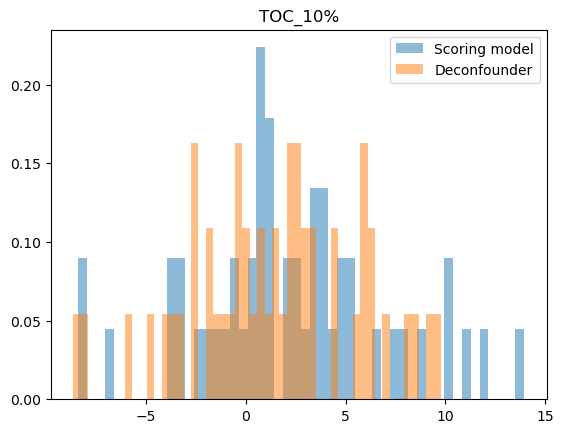

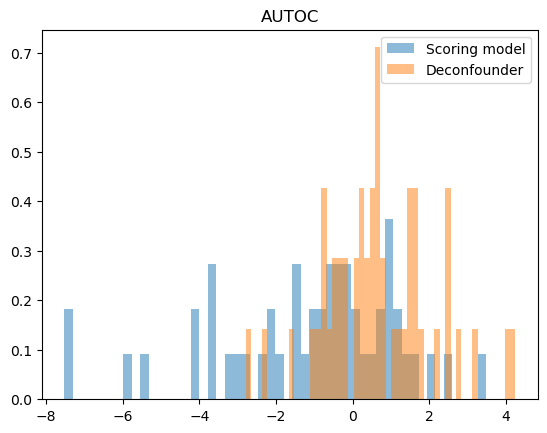

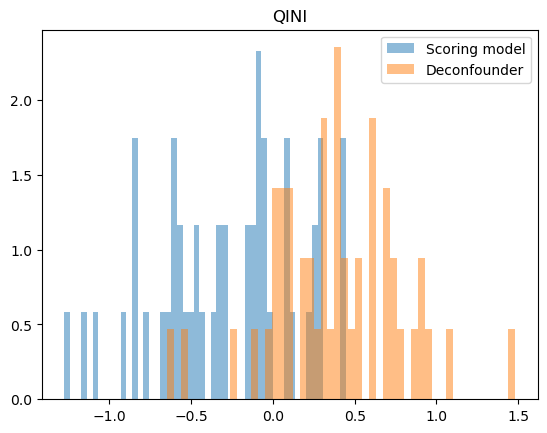

In [11]:
rep_num = 50

# Evaluation scores
eval_res = {'TOC_10%': np.empty((2, rep_num)), 'AUTOC': np.empty((2, rep_num)), 'QINI': np.empty((2, rep_num))}

for i in range(rep_num):

    state = random.randint(1, 1e5)

    # Split data into train and test set
    X_dec, X_test, Y_dec, Y_test, T_dec, T_test = train_test_split(X_exp, Y_exp, T_exp, test_size=0.5, random_state=state)

    # Fit scoring model
    X_sm = pd.concat([X_dec[T_dec==0], X_all[T_all==3]], axis=0)
    Y_sm = np.r_[Y_dec[T_dec==0], Y_all[T_all==3]]

    scoring_model = clone(best_sm_model)
    scoring_model.fit(X_sm, Y_sm)

    # Fit deconfounder tree
    priority_score_dec = -1 * scoring_model.predict(X_dec.values)
    deconfounder = clone(best_deconfounder)
    deconfounder.fit(X_dec.values, np.c_[T_dec, Y_dec, priority_score_dec, np.zeros(X_dec.shape[0])])

    # Score on test set
    priority_score = -1 * scoring_model.predict(X_test.values)
    corrected_score = priority_score - deconfounder.predict(X_test.values)

    for metric, values in eval_res.items():
        values[0][i] = evaluate(metric, Y_test, priority_score, T_test, k=0.1)
        values[1][i] = evaluate(metric, Y_test, corrected_score, T_test, k=0.1)


for metric, values in eval_res.items():
    plt.hist(values[0], alpha = 0.5,label='Scoring model', bins=50, density=True)
    plt.hist(values[1], alpha = 0.5,label='Deconfounder', bins=50, density=True)
    plt.title(metric)
    plt.legend()
    plt.show()


# Analysis by Carlos

<Axes: xlabel='effects', ylabel='scores'>

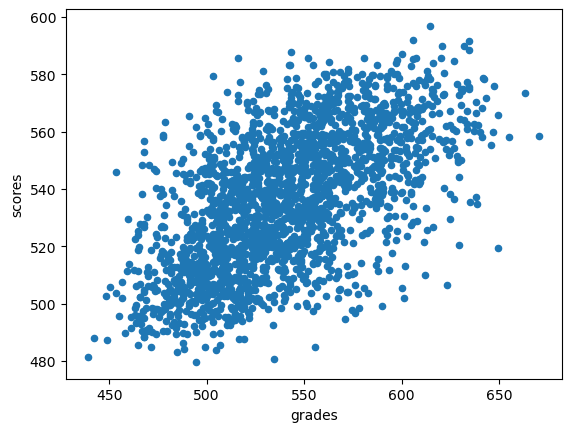

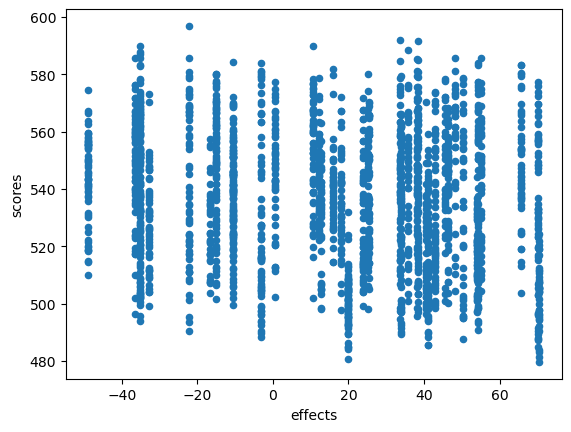

In [13]:
scores = best_sm_model.predict(X_test)
eff = causal_model.predict(X_test)
data = pd.DataFrame({"scores": scores, "effects": eff, "grades": Y_test})
data.plot.scatter("grades", "scores")
data.plot.scatter("effects", "scores")
# Conclusion: The predictive model is good for predicting grades, 
# but grades do not seem to be  correlated with effects.

Compare decision making of various alternatives.

In [25]:
def causal_impact(decisions):
    target_size = decisions.mean()
    Yt = Y_test[(T_test == 1) & decisions].mean()
    Yc = Y_test[(T_test == 0) & decisions].mean()
    return target_size * (Yt - Yc)

random.seed(42)
state = random.randint(1, 1e5)
# Split data into train and test set
X_dec, X_test, Y_dec, Y_test, T_dec, T_test = train_test_split(X_exp, Y_exp, T_exp, test_size=0.5, random_state=state)

print(f"Target everyone: {causal_impact(np.full(Y_test.size, True)):.2f}")
effects = causal_model.predict(X_test)
effect_targets = effects > 0
print(f"Target w. effects: {causal_impact(effect_targets):.2f}")
scores = -best_sm_model.predict(X_test)
s_boundary = np.percentile(scores, 100 - effect_targets.mean()*100)
score_targets = scores >= s_boundary
print(f"Target w. scores: {causal_impact(score_targets):.2f}")
corrected_scores = scores - best_deconfounder.predict(X_test.values) 
print(f"Target w. corrected scores: {causal_impact(corrected_scores>0):.2f}")

# Conclusion: It doesn't make sense that the deconfounder tree would lower the result of the
# scoring model. I suspect there is something wrong with the implementation. 

Target everyone: 11.45
Target w. effects: 13.41
Target w. scores: 6.24
Target w. corrected scores: 5.41
